Webpage: [https://v993.github.io/](https://v993.github.io/)

## Project Milestone 2

![Alt text](capitol_banner.jpg)

# Project Goals: Analysis of Congressional Representatives
#### Author: Leonardo Matone


In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Congress has increasingly become more polarized and complicated in recent decades, and these preliminary investigations are a testament to that. Understanding and quantifying politicians specifically contextualized against one another could be a useful tool towards understanding where politicians lie (no pun intended), and how they can be described. In this project, I hope to use data on political representatives to quantify their political ideologies, similarly to Keith Poole and Howard Rosenthal's NOMINATE model which utilizes roll call votes to build ideological scores for representatives. I will be using these NOMINATE scores along with publicly available member data to find patterns in how representatives vote, and predict things about new/unknown representatives based on their voting or other features of their person in the context of their peers. The main goal of this project is to make large-scale politics more digistible. I've done some work on this in the past ([New York Data Project](https://github.com/V993/LegislativeDataAnalytics)) but never in a learning capacity (i.e. machine learning). My work will be centered in this [website](https://v993.github.io/).

At this stage, the problem questions are three:
- Are data on representatives alone adequate to predict NOMINATE scores?
- Can a model predict NOMINATE scores using voting data and representative information?
- Can NOMINATE scores be used to predict features of a representative (e.g. age, aspects of constituency, finances)

### Data/Resources:

I plan to use the following sources of data:

1. [VoteView](https://voteview.com/articles/data_help_members) political polarization data
2. [VoteView](https://voteview.com/articles/data_help_members) congressional votes data
3. [US Census](https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html) data from the IRS, specifically SAIPE (Small Area Income and Poverty Estimates)
4. [OpenSecrets](https://www.opensecrets.org/) data on lobbying, campaign finance, and personal finances for congressional representatives (not included here)

I will focus specifically on House representatives. There are more representatives to train on, and I believe we will encounter more variance on a lower level of congress.

## Extraction, Transform, and Load:

### VoteView Political Polarization:
Includes basic information about representatives, and several dimensions of their ideological scores based on voting.

Source: https://voteview.com/articles/data_help_members

In [2]:
voteview_polarization_df = pd.read_csv("member_ideology_house_all_years.csv")

# Remove president from assessment:
voteview_polarization_df = voteview_polarization_df[voteview_polarization_df["chamber"]=="House"]
voteview_polarization_df.head()

,congress,chamber,icpsr,state_icpsr,district_code,state_abbrev,party_code,occupancy,last_means,bioname,...,died,nominate_dim1,nominate_dim2,nominate_log_likelihood,nominate_geo_mean_probability,nominate_number_of_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2
1,1,House,379,44,2.0,GA,4000,0.0,1.0,"BALDWIN, Abraham",...,1807.0,-0.165,-0.373,-28.55029,0.758,103.0,12.0,NaN,-0.429,-0.817
2,1,House,4854,44,1.0,GA,4000,0.0,1.0,"JACKSON, James",...,1806.0,-0.320,-0.181,-24.89986,0.776,98.0,9.0,NaN,-0.559,-0.052
3,1,House,6071,44,3.0,GA,4000,0.0,1.0,"MATHEWS, George",...,1812.0,-0.428,-0.317,-12.62728,0.880,99.0,2.0,NaN,-0.413,-0.232
4,1,House,1538,52,6.0,MD,5000,0.0,1.0,"CARROLL, Daniel",...,1796.0,0.116,-0.740,-23.47008,0.783,96.0,11.0,NaN,0.114,-0.779
5,1,House,2010,52,3.0,MD,4000,0.0,1.0,"CONTEE, Benjamin",...,1815.0,-0.080,-0.387,-21.88695,0.788,92.0,13.0,NaN,-0.093,-0.411


#### Add "state_name" field for merge down the line:

We'll need this field with our other data sources in order to properly merge using state data. Using the below dictionary, we can easily create a state_name column: 

In [3]:
state_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District Of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

In [4]:
voteview_polarization_df["state_name"] = voteview_polarization_df["state_abbrev"].apply(lambda x: state_mapping[x])

#### Field Breakdown:
##### Bio Fields:

- **icpsr**: Integer 1-99999. Unique ID code for each member. Some members have recieved more than one, so this will need to be cleaned.
- **state_icpsr**: Integer 0-99. Identifier for the state represented by the member.
- **district_code**: Integer 0-99. Identifier for the district that the member represents within their state (e.g. 3 for the Alabama 3rd Congressional District). Senate members are given district_code 0. Members who represent historical "at-large" districts are assigned 99, 98, or 1 in various circumstances. This will likely not be needed for learning, and as I couldn't find a good source of national district data, we won't be able to use it constructively.
- **state_abbrev**: String. Two-character postal abbreviation for state (e.g. MO for Missouri).
- **party_code**: Integer 1-9999. Identifying code for the member's party. We can construct a mapping from resources documented by the source down the road, but this means we don't need to do as much encoding for party_code, aside from rendering this discretized.
- **occupancy**: Integer 1+. ICPSR occupancy code. This item is considered legacy or incomplete information and has not been verified. We will remove this from our table.
- **last_means**: Integer 1-5. ICPSR Attain-Office Code. This item is considered legacy or incomplete information and has not been verified. We will remove this from our table.
- **bioname**: String. Name of the member, surname first. 
- **bioguide_id**: String. Member identifier in the Biographical Directory of Congress. Because we won't be using the Biographical Directory of Congress, this can be removed from our table. 
- **born**/**died**: Integer. Year of member's birth/death. We can combine these two into an "age" field for members who are still alive, by using the year of congress which they held office in.

##### Ideological Fields:

This is the center of this project. Keith Poole and Howard Rosenthal developed the NOMINATE model/estimator, which places legislators in an abstract ideological space with the goal of quantifying a representative's ideology. Legislators are evaluated based on voting patterns, and placed in a primarily liberal-conservative ideological axis that describes preferences over issues in politics, including taxation, spending, and civil rights.

There are two estimates present here: NOMINATE and Nokken-Poole. We will use both in our assessments if possible. 

- **nominate_dim1:** NOMINATE first dimension estimate.
- **nominate_dim2**: NOMINATE second dimension estimate.
- **log_likelihood**: Log-likelihood of the NOMINATE estimate.
- **geo_mean_probability**: Geometric mean probability of NOMINATE estimate.
- **number_of_votes**: Number of votes cast by the member during a given congress.
- **conditional**: Integer 0-1. A 1 indicates NOMINATE was estimated conditionally for a given member. We won't need this value for our estimation, so we can drop it entirely.
- **nokken_poole_dim1**: Nokken-Poole First dimension estimate.

In [5]:
# Drop values noted above:
drop = ["district_code", "occupancy", "conditional"]
voteview_polarization_df.drop(drop, axis=1, inplace=True)

### US Census SAIPE:
Includes data from the IRS collected by the US Census on Small Area Income and Poverty Estimates

Source: https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html

In [6]:
### US Census SAIPE data:
saipe_df = pd.read_excel("irs.xls",skiprows=2)

saipe_df.head()

,State FIPS code,Name,Year,Total exemptions,Poor exemptions,Age 65 and over exemptions,Age 65 and over poor exemptions,Child exemptions,Poor child exemptions,Total exemptions under age 65,Poor exemptions under age 65,Median AGI,Mean AGI
0,1,Alabama,1989,3367441,634363,213228,30357,1145821,260472,3154213,604006,18271,26487
1,1,Alabama,1990,3427361,676616,223095,34114,1175534,281392,3204266,642502,18719,27300
2,1,Alabama,1991,3471467,720465,229666,36826,1193227,304653,3241801,683639,18929,27941
3,1,Alabama,1992,3494455,711496,227683,35158,1210348,305209,3266772,676338,19508,29397
4,1,Alabama,1993,3518338,728239,227765,35485,1220397,314438,3290573,692754,19775,29846


#### Getting sessions of congress from year values in SAIPE:

Each observation is on a year basis. We want to get our data on a per-session of congress observational level. To accomplish the transformation, we can extract each two year session of congress from the table, average their values, and save them in the resulting table which will contain the session of congress.

Because our data starts in the year 1989, we will have to restrict our data from other sources to be within the same bounds (1989-2020). We can accomplish this with a left merge per session of congress on our new table and our VoteView data. First, let's transform our data to be in the form we require.

Sessions of congress start on odd-numbered years and last for 2 years, ending on January 3rd of the even-numbered year and starting on January 4th. Converting the years is quick once we verify the session of congress in 1989, which is the starting year of the 101st session of congress. Now we can iteratively add to our congressional session and save in the "congress" column. Setting the value of "congress" to be 101 + (year-1988)//2 results in an iterator over our dataset which increases every two years:

In [7]:
congress = 101
saipe_df["congress"] = saipe_df["Year"].apply(lambda x: congress+((x-1989)//2))
saipe_df[["Year", "congress"]].head(5) # Let's view the year and congress mappings to ensure they are accurate:

,Year,congress
0,1989,101
1,1990,101
2,1991,102
3,1992,102
4,1993,103


#### Merging year rows by sessions of congress:

With each session of congress marked, we need to average the values of each session for each state and add them to our resultant table. At this stage, I found it prudent to complete a few other minor cleaning steps:
- Combined year values into a "year_range" column containing both years of the congressional session for reference
- Casted "State FIPS code" to int, it shouldn't be a floating point value
- Session of congress should also be int, not a floating point
- Drop "Year" and "State FIPS code" values as they are outdated
- lowercase all columns and perform a minor reorganization before our merge

In [8]:
# Average values by congressional session and combine rows (using the average)
saipe_df_clean = pd.DataFrame()
for congress in saipe_df["congress"].unique():
    df_congress = saipe_df[saipe_df["congress"] == congress].groupby("Name").mean()
    df_congress.reset_index(inplace=True)
    df_congress["year_range"] = df_congress["Year"].apply(lambda x: f"{int(x-0.5)}-{int(x+1.5)}") # Fix year formatting
    df_congress["state_FIPS"] = df_congress["State FIPS code"].astype(int) # cast to int instead of float
    df_congress["congress"] = df_congress["congress"].astype(int)
    df_congress.drop(["Year","State FIPS code"],axis=1,inplace=True) # Remove outdated year and FIPS code columns

    new_columns = {old_name:old_name.lower() for old_name in df_congress.columns} # lowercase columns
    new_columns["Name"] = "state_name" # rename "name" to more accurate "state_name"
    df_congress = df_congress.rename(columns=new_columns)
    df_congress = df_congress[["congress", "year_range", "state_name", "state_fips", 'total exemptions', 'poor exemptions',
       'age 65 and over exemptions', 'age 65 and over poor exemptions',
       'child exemptions', 'poor child exemptions',
       'total exemptions under age 65', 'poor exemptions under age 65',
       'median agi', 'mean agi']] # reorganize dataframe
    
    saipe_df_clean = pd.concat([saipe_df_clean,df_congress],ignore_index=True)

saipe_df_clean.head()

,congress,year_range,state_name,state_fips,total exemptions,poor exemptions,age 65 and over exemptions,age 65 and over poor exemptions,child exemptions,poor child exemptions,total exemptions under age 65,poor exemptions under age 65,median agi,mean agi
0,101,1989-1991,Alabama,1,3397401.0,655489.5,218161.5,32235.5,1160677.5,270932.0,3179239.5,623254.0,18495.0,26893.5
1,101,1989-1991,Alaska,2,465887.0,45027.5,15669.0,1372.0,158544.0,15505.0,450218.0,43655.5,28586.0,37396.0
2,101,1989-1991,Arizona,4,3056550.0,556156.5,285017.5,30618.5,1001303.5,231076.0,2771532.5,525538.0,19989.0,28816.5
3,101,1989-1991,Arkansas,5,1965089.0,420454.0,157183.5,25159.5,650393.0,167440.0,1807905.5,395294.5,17121.0,24032.0
4,101,1989-1991,California,6,24348109.5,3807503.0,1894756.0,173023.5,7753444.0,1532522.5,22453353.5,3634479.5,23399.0,35051.0


#### Re-casting averaged values into whole numbers:

In [9]:
for column in saipe_df_clean.columns:
    if saipe_df_clean[column].dtype == float:
        saipe_df_clean[column] = saipe_df_clean[column].astype(int)

saipe_df_clean.dtypes

congress                            int64
year_range                         object
state_name                         object
state_fips                          int64
total exemptions                    int64
poor exemptions                     int64
age 65 and over exemptions          int64
age 65 and over poor exemptions     int64
child exemptions                    int64
poor child exemptions               int64
total exemptions under age 65       int64
poor exemptions under age 65        int64
median agi                          int64
mean agi                            int64
dtype: object

#### Removing District of Columbia from table:
Our VoteView data does not include any values from the District of Columbia because the District of Columbia does not have any voting representation in congress. The Census data treats the district the same as a state, which is probably why their state name column was just "name." We can remove this column to avoid issues merging later.

In [10]:
columbia_filter = saipe_df_clean["state_name"] == "District of Columbia"
saipe_df_clean.drop(saipe_df_clean[columbia_filter].index,inplace=True)

#### Getting party names from party codes:

VoteView stores its party information in integer codes. They have a conversion .csv file which we can use to get the party name from party code for readability. We will likely have to one-hot encode these categorical variables down the line, but for EDA, I'd like to have the names handy. We can start with the .csv, convert to a dataframe, and read what we need into a dictionary for use:

(there are some great names in here. "Readjuster democrat" is my favorite, and actually held some pretty cool values from a quick search)

In [11]:
# get a unique mapping of all parties the US has ever had registered:
parties_df = pd.read_csv("HSall_parties.csv")
parties_df = parties_df.groupby(['party_code','party_name'])["n_members"].sum().reset_index().rename(columns={'n_members':'count_all_time'})

parties = {party_code:parties_df[parties_df["party_code"] == party_code]["party_name"].item() for party_code in parties_df["party_code"].unique()}
# parties

### Left join on SAIPE data with VoteView data:
We want to merge on SAIPE as to only include records where we know the income and poverty estimates, so a left join is perfect. We can also reorganize our data here to be more indicative of the different types of data we have stored, and add a party_name column for readability:

In [12]:
columns = [
    # Rep info
    'congress', 'bioname', 'party_code', 'party_name', 'born', 'died',
    'year_range', 'state_name', 'state_abbrev', 'icpsr', 'state_icpsr', 
    'state_fips',
    
    # Rep ideology
    'nominate_dim1', 'nominate_dim2', 'nominate_log_likelihood',
    'nominate_geo_mean_probability', 'nominate_number_of_votes',
    'nominate_number_of_errors', 'nokken_poole_dim1',
    'nokken_poole_dim2', 
    
    # State demographics
    'total exemptions', 'poor exemptions', 'age 65 and over exemptions',
    'age 65 and over poor exemptions', 'child exemptions',
    'poor child exemptions', 'total exemptions under age 65',
    'poor exemptions under age 65', 'median agi', 'mean agi',
]


df = pd.merge(
    saipe_df_clean,
    voteview_polarization_df,
    how="left",
    on=["congress", "state_name"]
).reset_index().drop(["chamber","index"], axis=1)

df["party_name"] = df["party_code"].apply(lambda x: parties[x])

df=df[columns]

df.head()

,congress,bioname,party_code,party_name,born,died,year_range,state_name,state_abbrev,icpsr,...,total exemptions,poor exemptions,age 65 and over exemptions,age 65 and over poor exemptions,child exemptions,poor child exemptions,total exemptions under age 65,poor exemptions under age 65,median agi,mean agi
0,101,"DICKINSON, William Louis",200,Republican,1925.0,2008.0,1989-1991,Alabama,AL,10717,...,3397401,655489,218161,32235,1160677,270932,3179239,623254,18495,26893
1,101,"BEVILL, Tom",100,Democrat,1921.0,2005.0,1989-1991,Alabama,AL,11000,...,3397401,655489,218161,32235,1160677,270932,3179239,623254,18495,26893
2,101,"NICHOLS, William Flynt",100,Democrat,1918.0,1988.0,1989-1991,Alabama,AL,11037,...,3397401,655489,218161,32235,1160677,270932,3179239,623254,18495,26893
3,101,"FLIPPO, Ronnie Gene",100,Democrat,1937.0,NaN,1989-1991,Alabama,AL,14419,...,3397401,655489,218161,32235,1160677,270932,3179239,623254,18495,26893
4,101,"ERDREICH, Ben",100,Democrat,1938.0,NaN,1989-1991,Alabama,AL,15022,...,3397401,655489,218161,32235,1160677,270932,3179239,623254,18495,26893


#### Convert "died" and "born" to "age" column:

Now that we have the years of each congressional session, we can calculate a representative's age, and replace both columns with an "age" column. Something we can do with relative ease as there are no missing values for "born":

In [13]:
def get_age(x):
    born = x["born"]
    died = x["died"]
    year_start = int(x["year_range"][:4])
    if not pd.isna(died):
        age = died - born
    else:
        age = year_start - born
    return age

df["age"] = df.apply(lambda x: get_age(x), axis=1)
df.drop(["died"], axis=1, inplace=True)


Shift "age" to the beginning of our dataframe:

In [14]:
df = df[['congress', 'bioname', 'party_code', 'party_name', 'age', 'born',
       'year_range', 'state_name', 'state_abbrev', 'icpsr', 'state_icpsr',
       'state_fips', 'nominate_dim1', 'nominate_dim2',
       'nominate_log_likelihood', 'nominate_geo_mean_probability',
       'nominate_number_of_votes', 'nominate_number_of_errors',
       'nokken_poole_dim1', 'nokken_poole_dim2', 'total exemptions',
       'poor exemptions', 'age 65 and over exemptions',
       'age 65 and over poor exemptions', 'child exemptions',
       'poor child exemptions', 'total exemptions under age 65',
       'poor exemptions under age 65', 'median agi', 'mean agi']]

#### Remove NaNs:
There are three values in our final(ish) table which have NaNs in the "nominate_dim1" column, which we require for our anaylsis:

In [15]:
df[df["nominate_dim1"].isna()]

,congress,bioname,party_code,party_name,age,born,year_range,state_name,state_abbrev,icpsr,...,total exemptions,poor exemptions,age 65 and over exemptions,age 65 and over poor exemptions,child exemptions,poor child exemptions,total exemptions under age 65,poor exemptions under age 65,median agi,mean agi
3929,109,"SEKULA GIBBS, Shelley",200,Republican,52.0,1953.0,2005-2007,Texas,TX,20541,...,19527026,3878915,1331733,198688,6845411,1638598,18195293,3680227,30912,58004
6783,116,"HALL, Kwanza",100,Democrat,48.0,1971.0,2019-2021,Georgia,GA,21991,...,8590167,2017787,927451,164205,2637395,707319,7662716,1853582,35587,68412
6871,116,"MITCHELL, Paul",328,Independent,65.0,1956.0,2019-2021,Michigan,MI,91737,...,8442286,1685096,1358354,289547,2275301,499879,7083931,1395549,39413,67771


For the time being, I will remove them to proceed with EDA. But I will revist them as I finalize my DataFrame for the final project, just to make sure I can't compute their values using a kNN. We could even use these as a small test set down the line.

In [16]:
df.drop(df[df["nominate_dim1"].isna()].index, inplace=True)

### [NOT INTEGRATED, ONLY EXTRACTED] VoteView Vote data:
This data is much larger than our other two datasets. VoteView's vote tables are observations on bills, which members vote on. The form of this particular table is on a member level, where each observation is a member's vote on a particular bill. The ICPSR is a direct mapping to the same value in table we have above with members, but there are **21,280,071** records in this votes table. I need to do a little more research on how I can represent a member's vote in the schema I have planned. I'll see if Prof has any advice before I continue, but here is the data:

In [17]:
voteview_votes_df = pd.read_csv("all_reps_votes.csv", low_memory=False)
voteview_votes_df.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,1,House,1,154.0,6.0,61.1
1,1,House,1,259.0,9.0,99.6
2,1,House,1,379.0,1.0,100.0
3,1,House,1,649.0,1.0,59.2
4,1,House,1,786.0,1.0,97.7


### Fields:

- **congress**: Integer 1+. The number of the congress that this member's row refers to. e.g. 115 for the 115th Congress (2017-2019)
- **chamber**: House, Senate, or President. The chamber in which the member served.
- **rollnumber**: Integer 1+. Starts from 1 in the first rollcall of each congress. Excludes quorum calls and vacated votes.
- **icpsr**: Integer 1-99999. This is an ID code which identifies the member in question. In general, each member receives a single ICPSR identifier applicable to their entire career. A small number of members have received more than one- this can occur for members who have switched parties; as well as members who subsequently become president. Creating a new identifier allows a new NOMINATE estimate to be produced for separate appearances of a member in different roles.
- **cast_code**: Integer 0-9. Indicator of how the member voted.
- **prob**: Estimated probability, based on NOMINATE, of the member making the vote as recorded.


### Cast codes:
We can use this mapping down the line to possibly remove or combine some of these classifications. Pretty certain "Yea" and "Paired Yea" can mean the same to our model, but it does merit some more research.

In [18]:
cast_code_mapping = {
    "0" : "Not a member of the chamber when this vote was taken",
    "1" : "Yea",
    "2" : "Paired Yea",
    "3" : "Announced Yea",
    "4" : "Announced Nay",
    "5" : "Paired Nay",
    "6" : "Nay",
    "7" : "Present (some Congresses)",
    "8" : "Present (some Congresses)",
    "9" : "Not Voting (Abstention)"
}

## Exploratory Data Analysis (EDA):

In [19]:
matplotlib.rcParams.update({'font.size': 22}) # I am blind

### Basic (but interesting) statistics:

#### Age in the House:
Let's dive into the age values in congress and see what our demographics are like:


In [20]:
print("Average age between 1989-2020:", df["age"].mean())
print("Median age between 1989-2020:", df["age"].median())
print("Max age in between 1989-2020:", df["age"].max())

Average age between 1989-2020: 58.08426095533324
Median age between 1989-2020: 56.0
Max age in between 1989-2020: 101.0


Definitely not a hip crowd by any metric. Not sure how a 101 year old held a public office within the last 3 decades.

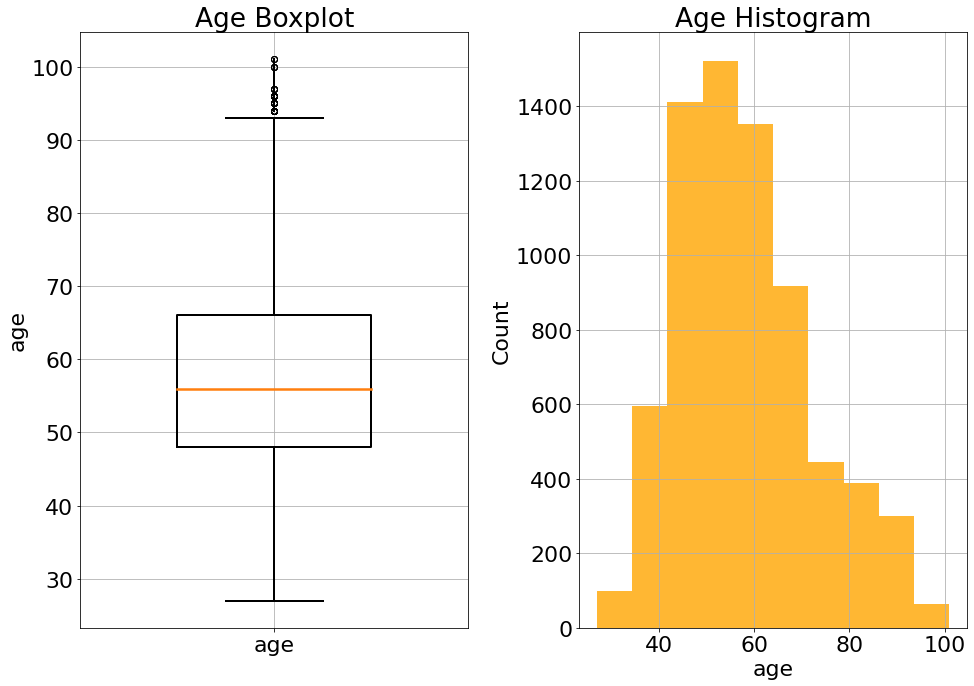

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,10))

df["age"].plot.box(
    color=dict(medians='r'),
    widths=0.5,
    boxprops=dict(linestyle='-', linewidth=2),
    flierprops=dict(linestyle='-', linewidth=2),
    medianprops=dict(linestyle='-', linewidth=2.5),
    whiskerprops=dict(linestyle='-', linewidth=2),
    capprops=dict(linestyle='-', linewidth=2),
    grid=True,
    ax=ax1)
ax1.set_ylabel("age")
ax1.title.set_text("Age Boxplot")


ax2.hist(df["age"],color="orange",alpha=0.8)
ax2.set_ylabel("Count")
ax2.set_xlabel("age")
ax2.title.set_text("Age Histogram")
ax2.grid()

fig.tight_layout()

The results of these plots are a little scary- regardless of the idiom that "with age comes wisdom." Considering how difficult it has been to find data on congressional representatives, it will be interesting to see how age impacts a representative's polarity, especially with such a spread of data. The historgram on the right shows a right skew, and that tail is far longer than I think it should be. Luckily, that means we should have some interesting plots with age due to the variance of age in the House.

#### Party representation in the house:

In [22]:
# Make party dataframes func
def get_party_df(party):
    return df[df["party_name"]==party]

# Output some basic information about parties in congress and build dataframes
party_dfs = []
for party in df["party_name"].unique():
    party_df = get_party_df(party)
    party_dfs.append((party, party_df))
    print(f"{party}: {len(party_df)} aggregate congressional seats from 1989-2020")


Republican: 3497 aggregate congressional seats from 1989-2020
Democrat: 3589 aggregate congressional seats from 1989-2020
Independent: 11 aggregate congressional seats from 1989-2020


Considering how few independents there have been between 1989-2020, and the factor of 100 between Independents and Democrats/Republicans, I have elected to remove them from party-based plots. For assessments of the entirety of the house, these reps can stay.

### A Brief Aside on the  NOMINATE System:

- The first dimension picks up differences in **ideolology**, which is represented through the "liberal" vs. "conservative" (also referred to as "left" vs. "right") proportions throughout American history. Negative denotes a liberal disposition, positive a conservative.
- The second dimension picks up differences **within** the major political parties over slavery, currency, nativism, civil rights, and lifestyle issues during periods of American history.

When I first plotted these, I was including data exclusively from the 116th session of congress. Using the 101st session from 1989, we can see a little of what modern political science frequently (and unnecessarily) reminds us: [America is becoming more polarized](https://carnegieendowment.org/2023/09/05/polarization-democracy-and-political-violence-in-united-states-what-research-says-pub-90457). The difference is pretty striking visually:

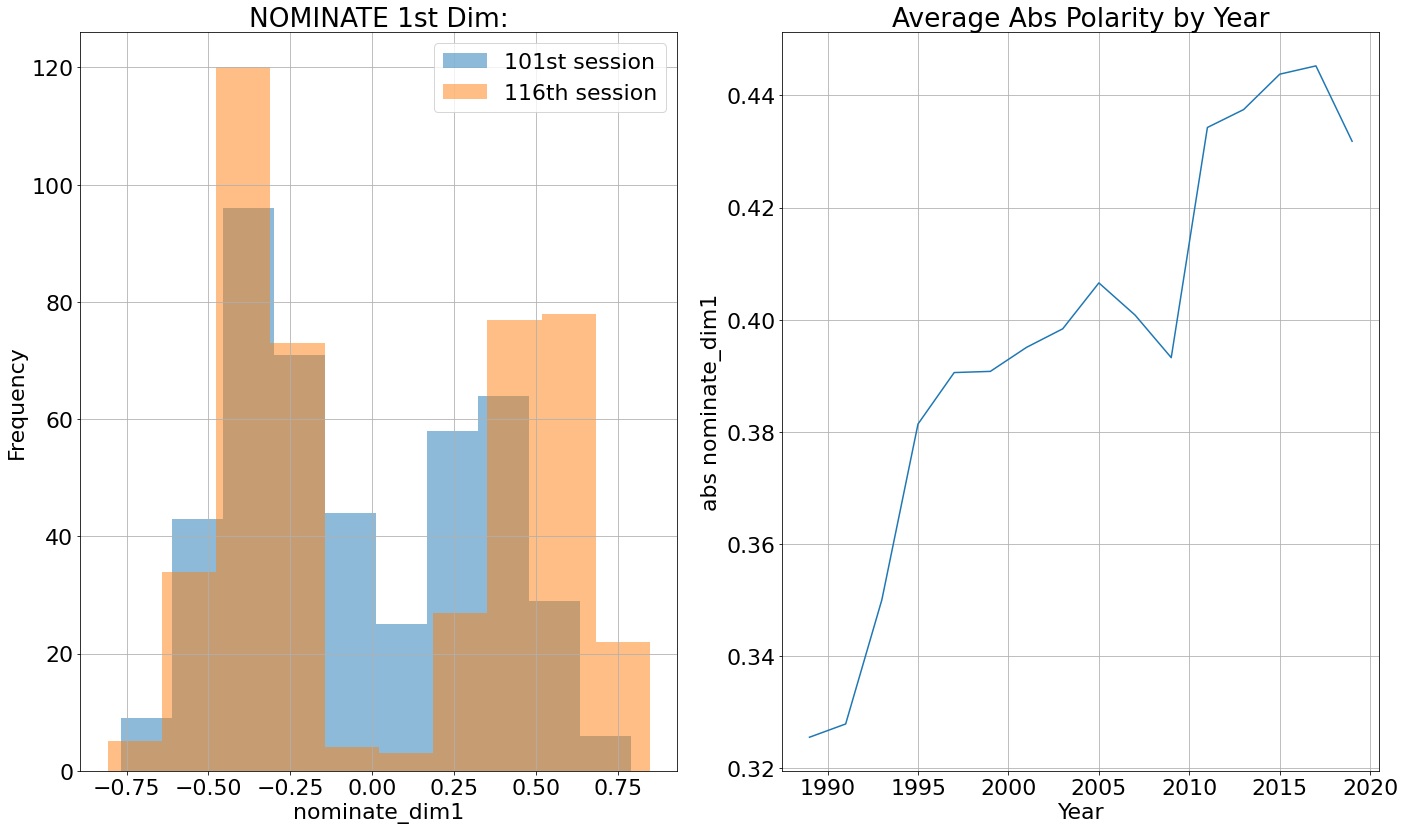

In [23]:
congress116 = df[df["congress"]==116]
congress101 = df[df["congress"]==101]

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,12))

ax1.set_xlabel("nominate_dim1")
ax1.set_ylabel("Frequency")
ax1.hist(congress101["nominate_dim1"], alpha=0.5, label="101st session")
ax1.hist(congress116["nominate_dim1"], alpha=0.5, label="116th session")
ax1.legend(loc='upper right')
ax1.title.set_text("NOMINATE 1st Dim:");
ax1.grid()

all_years = df["year_range"].unique()
year_mask = [df[df["year_range"]==year]["nominate_dim1"].abs().mean() for year in all_years]
all_years = [int(year[:4]) for year in all_years]
ax2.plot(all_years,year_mask)
ax2.set_xlabel("Year")
ax2.set_ylabel("abs nominate_dim1")
ax2.title.set_text("Average Abs Polarity by Year")
ax2.grid()

fig.tight_layout()

Comparing the 116th session of congress against the trend historically, we can see that the divide down ideological divides in the first dimension is far larger in the 116th session. There are fewer than 10 representatives with a nominate score less than 0.25 away from zero. Back in 1989, we had almost 80. The division between ideologies is pretty evident here across the board, but it is certainly growing larger. Plotting average absolute nominate_dim1, we can see that the average polarity (distance from 0, a moderate ideology) has increased steadily for the last three decades.

#### NOMINATE scores for each party with respect to poor exemptions under age 65:

I am hoping in these plots to demonstrate some sort of relationship between the population of poor exemptions in the state of a representative and their polarity. To illustrate this, I have a plot for both democrats and republicans to evaluate both independently and see if there is any relationship in how representatives behave with changes in their consituency. In order to evaluate both sides of the political spectrum with respect to ideological zero (moderates), I have plotted the absolute values of polarization, with the color and size of the points on the scatterplot representing the number of poor exemptions in the home state of the representative. Lighter green is higher, and darker purple is lower. 

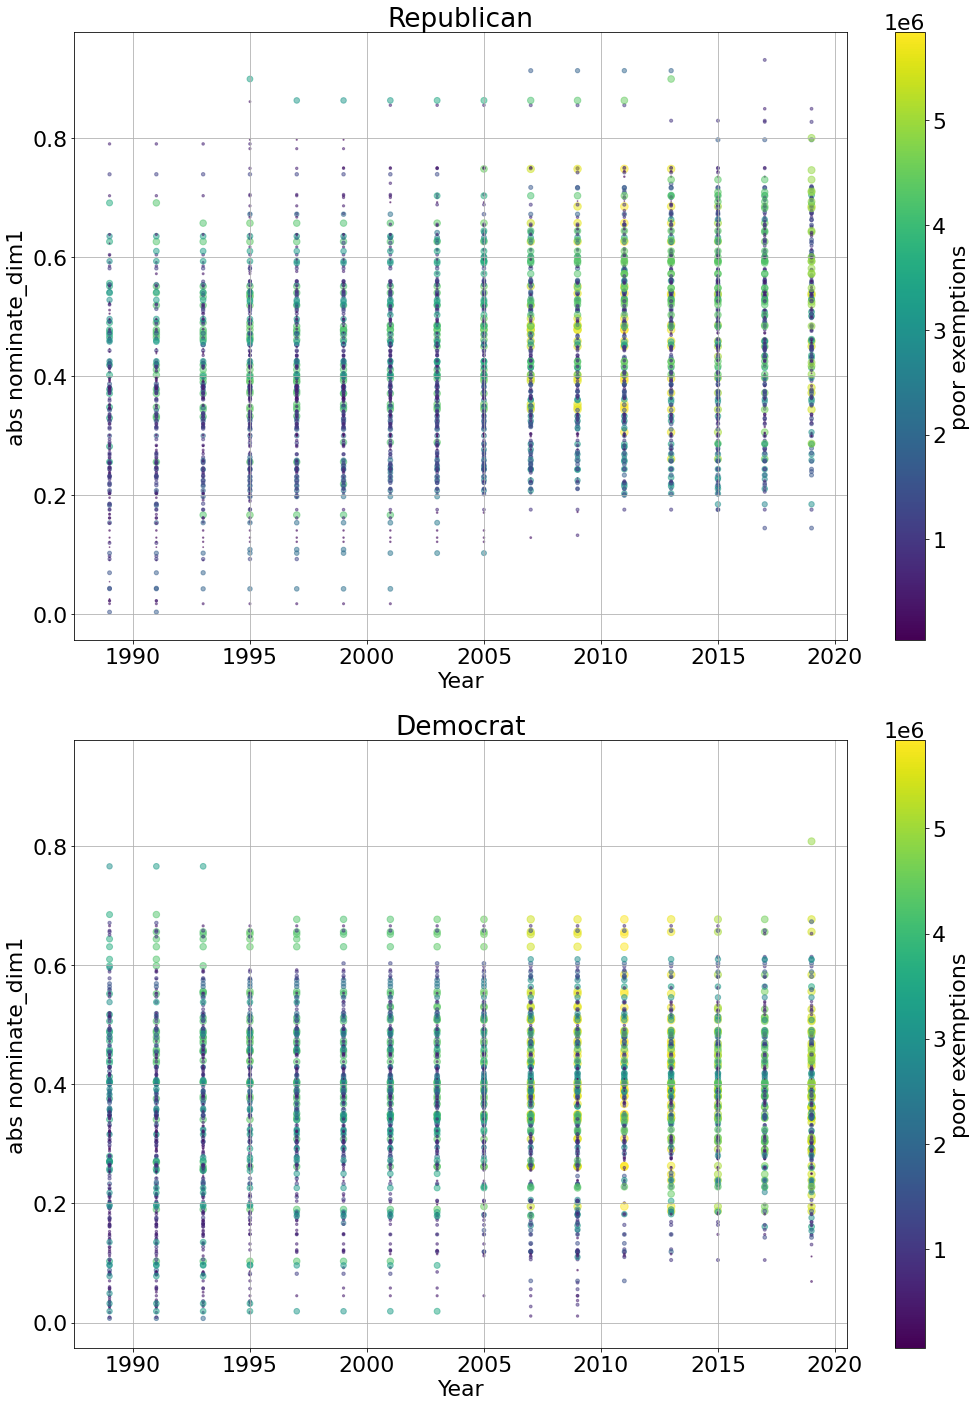

In [24]:

# Plot each party separately
fig, axs = plt.subplots(ncols=1,nrows=2,figsize=(15,20),sharey=True)
# fig.delaxes(axs[3])
# fig.delaxes(axs[2])
for (party,party_df),ax in zip(party_dfs, axs.ravel()):
    ax.scatter(
        party_df["year_range"].apply(lambda x: int(x[:4])), 
        party_df["nominate_dim1"].apply(lambda x: abs(x)),
        c=party_df["poor exemptions under age 65"], 
        s=party_df["poor exemptions under age 65"]/100000, 
        label="poor excemption",
        alpha=0.5)
    ax.tick_params(labelbottom=True)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("Year")
    ax.set_ylabel("abs nominate_dim1")
    ax.title.set_text(party)
    ax.grid()
    norm = mcolors.Normalize(min(party_df["poor exemptions under age 65"]), max(party_df["poor exemptions under age 65"]))
    sm = matplotlib.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, location="right", label="poor exemptions")


fig.tight_layout()

As we can see by the absolute values plotted, Democrats consistently toe the line around 0.7 NOMINATE_dim1, and typically do not exceed 0.7 (with a notable exception being 2020, I wonder why that could be). Republicans are definitely unafraid to cross a threshold of 0.8 NOMINATE_dim1, with the number of reps over 0.8 increasing after the 90s, with a parallel increase in the lower bound after 2000. 

Correlation between polarity and poor exemptions seems sparse, but not non-existent. For democrats, representatives from states with lower poor exemptions and higher poor exemptions seem to have the same variance across the board. But for republicans, there does seem to be a slight correlation between poor exemptions and the NOMINATE_dim1, where higher numbers of poor exemptions are typically higher on the NOMINATE_dim1 scale, and lower numbers poor exemptions are lower on the NOMINATE_dim1. There could be a positive relationship between poverty and polarity for republicans.

#### NOMINATE scores with respect to age in republicans/democrats: 

Now we'll dive a little deeper into age with respect to political party and polarization. I am hoping to find a dependency between age and polarity to some extent. Older representatives could vote more consistently moderate than younger, more aspirational and large-minded representatives. Let's see how this idea plays out:

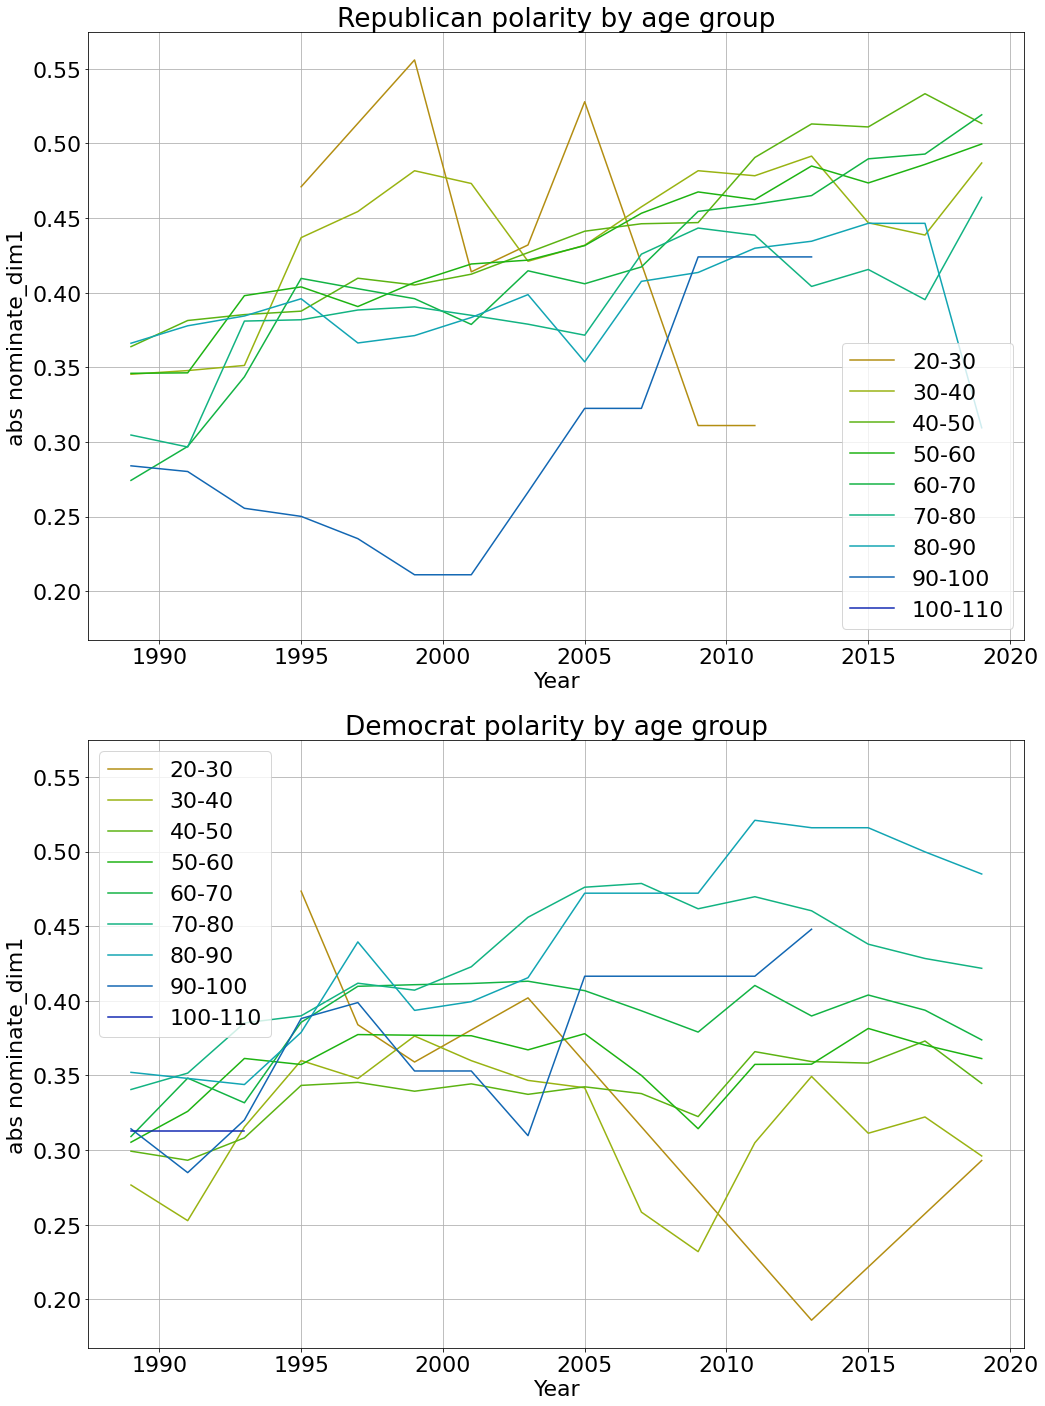

In [25]:

# Plot each party separately
fig, axs = plt.subplots(ncols=1,nrows=2,figsize=(15,20),sharey=True)
# fig.delaxes(axs[3])
# fig.delaxes(axs[2])

nvalues = range(0,110)

hsv2rgb = lambda hue: mcolors.hsv_to_rgb([hue,0.9,0.7])
hues = np.linspace(0, 0.7, len(nvalues))
colors = [hsv2rgb(hue) for hue in hues]

for (party,party_df),ax in zip(party_dfs, axs.ravel()):
    
    for age_group in range(20,110,10):
        age_mask = (age_group<party_df["age"]) & (party_df["age"]<=age_group+10)
        party_age_group = party_df[age_mask]
        all_years = party_age_group["year_range"].unique()
        average_polarity = [party_age_group[party_age_group["year_range"]==year]["nominate_dim1"].abs().mean() for year in all_years]
        all_years = [int(year[:4]) for year in all_years]
        ax.plot(all_years,average_polarity,label=f"{age_group}-{age_group+10}",color=colors[age_group])
        ax.tick_params(labelbottom=True)
        ax.tick_params(labelleft=True)
        ax.set_xlabel("Year")
        ax.set_ylabel("abs nominate_dim1")
        ax.title.set_text(party+" polarity by age group")
        ax.legend()
        ax.grid()


fig.tight_layout()

Similarly to poor exemptions, it seems that there is a difference in correlation rooted in political party. For republicans, polarity doesn't seem to have much correlation with age. Variance is lower, and age groups cluster after 2010 around 0.475 polarity. The color grading (darker=older) doesn't seem to be related to age.

For democrats, the opposite is true. We can see with the gradient that older representatives tend to be closer to 0.5 polarity, while younger representatives seem to be less polarized. This could be due to lack of voting data on newer representatives, but the correlation is definitely there.

#### Variance among parties

With these plots, I am hoping to understand the data a little better and recognize trends. I'm hoping there are historical changes for parties, and I'd like to see where these year groups diverge.

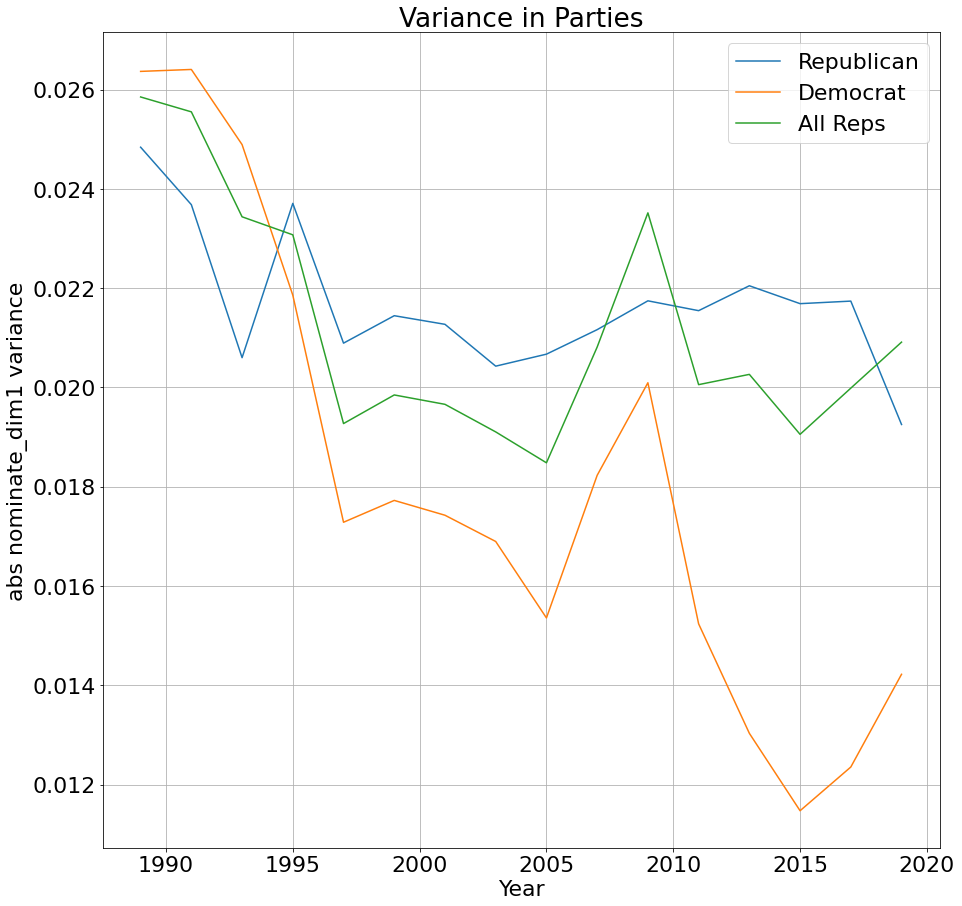

In [26]:
plt.figure(figsize=(15,15))

for (party,party_df) in party_dfs[:2]: # We will continue to exclude independents

    all_years = party_df["year_range"].unique()
    yearly_variance = [party_df[party_df["year_range"]==year]["nominate_dim1"].abs().var() for year in all_years]
    all_years = [int(year[:4]) for year in all_years]
    plt.plot(all_years,yearly_variance,label=party)

all_years = df["year_range"].unique()
yearly_variance = [df[df["year_range"]==year]["nominate_dim1"].abs().var() for year in all_years]
all_years = [int(year[:4]) for year in all_years]
plt.plot(all_years,yearly_variance,label="All Reps")

plt.xlabel("Year")
plt.ylabel("abs nominate_dim1 variance")
plt.title("Variance in Parties")
plt.legend()
plt.grid()

fig.tight_layout()

From the plot, it seems that democrats typically show less variance in polarity from moderates. Democrats are also more sporadic with change than republicans, who remain relatively consistent in terms of polarity over time. The fluctuations democrats experience do seem to be tied to their historical contexts. We can see a spike in polarity around 2008, a major electoral year for democrats, and a decline in the Obama years. Interestingly, it seems polarity started to increase again following Trump's election. 

## Models:

[NOTE] Sadly, but also excitedly, I must admit that most of these assessments were performed while waiting for OpenSecrets to open their secrets to me. As of this writing, I have the data! But too late for this report. That said, these are the preliminary models I am considering based off of the data in this report alone. I expect to change my data once I have explored what OpenSecrets has to offer, so this is all tentative. I expect to do more ETL before proceeding. 

Ideally, these models would also include a representative's finance information, both the size of donations to their campaign, and their personal finances if possible.

### Model 1:

Using voting data and representative data to predict NOMINATE
- Representative Age
- Party
- Poverty statistics by member's state from US Census
- Votes on bills

### Model 3:

Using NOMINATE scores to predict features of a representative:
- Age
- Party
- Votes on bills